<a href="https://colab.research.google.com/github/IgnacioIbanezSala/Forecasting/blob/main/Seq2SeqLoad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import math
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy as dc
from google.colab import files

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
data = pd.read_csv("data.csv")
print(data.head())
print(data.info())
print(data.describe())

   Unnamed: 0         EAST        WEST       NORTH         COAST
0           0  1302.296674  973.455700  757.843076  12054.939199
1           1  1259.355201  959.775908  737.236591  11793.290315
2           2  1210.287905  941.112359  725.610502  11460.841252
3           3  1179.311517  920.373708  717.420214  11244.980243
4           4  1171.841803  918.203309  719.178247  11073.085585
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8760 non-null   int64  
 1   EAST        8760 non-null   float64
 2   WEST        8760 non-null   float64
 3   NORTH       8760 non-null   float64
 4   COAST       8760 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 342.3 KB
None
        Unnamed: 0         EAST         WEST        NORTH         COAST
count  8760.000000  8760.000000  8760.000000  8760.000000   8760.000000
mean   4379.5000

In [ ]:
data

,Unnamed: 0,EAST,WEST,NORTH,COAST
0,0,1302.296674,973.455700,757.843076,12054.939199
1,1,1259.355201,959.775908,737.236591,11793.290315
2,2,1210.287905,941.112359,725.610502,11460.841252
3,3,1179.311517,920.373708,717.420214,11244.980243
4,4,1171.841803,918.203309,719.178247,11073.085585
...,...,...,...,...,...
8755,8755,1407.683729,1125.338906,938.901362,10247.562908
8756,8756,1362.637978,1103.919231,963.913723,9887.676773
8757,8757,1327.298817,1084.122587,949.798259,9572.382483
8758,8758,1237.913479,1058.601615,928.929373,9258.586996


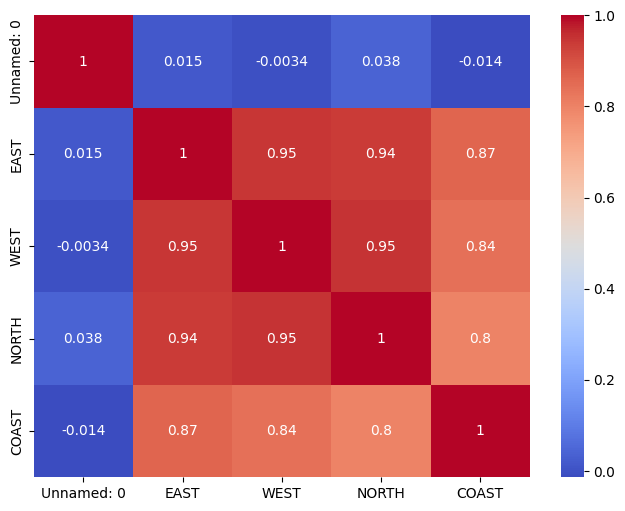

In [ ]:
numeric_data = data.select_dtypes(include = ["int64", "float64"])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.show()


In [ ]:
east_load = data.filter(["EAST"])
dataset = east_load.values

/tmp/ipython-input-1522381588.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


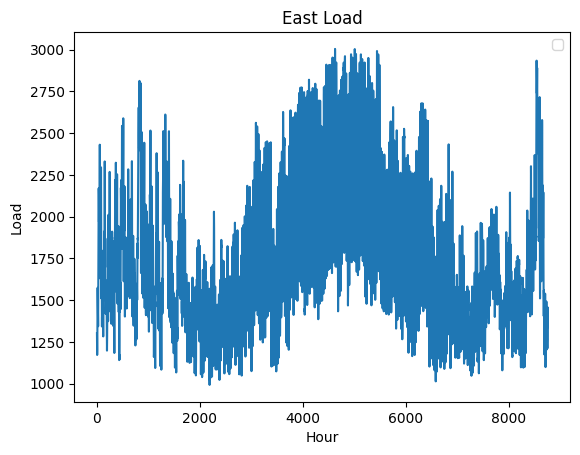

In [ ]:
plt.plot(dataset)
plt.title("East Load")
plt.xlabel('Hour')
plt.ylabel('Load')
plt.legend()
plt.show()

In [ ]:
percent_to_train = 95 #@param {type:"integer"}
training_data_len = int(np.ceil(len(dataset))*(percent_to_train/100))
print("Data to use for training: ", training_data_len)
print("Data to use for testing: ", (len(dataset) - training_data_len))

Data to use for training:  8322
Data to use for testing:  438


## KERAS LSTM CELL STRUCTURE

## <img src="https://github.com/kmkarakaya/ML_tutorials/blob/master/images/LSTM_internal2.png?raw=true" width="700">

* LSTM ***expects*** **input data** to be a **3D** tensor such that:

      [batch_size, timesteps, feature]

* **batch_size** how many samples in each batch during training and testing

* **timesteps** means how many values exist in a sequence. For example in [4, 7, 8, 4] there are 4 timesteps

* **features**: how many dimensions are used to represent a data in one time step.

In [ ]:
#@title Configure problem

n_timesteps_in = 200  #@param {type:"integer"}
#each input sample has 60 values

n_features = 1   #@param {type:"integer"}
#each value is one number


In [ ]:
def create_dataset(dataset, n_timesteps_in, n_features):
  X, Y = [], []
  for i in range(n_timesteps_in, len(dataset)-24):
    X.append(dataset[i-n_timesteps_in:i, 0])
    Y.append(dataset[i:i+24,0])
  X, Y = np.array(X), np.array(Y)
  X = np.reshape(X, (X.shape[0], X.shape[1], n_features))
  Y = np.reshape(Y, (Y.shape[0], Y.shape[1], 1))
  return torch.tensor(X).float(), torch.tensor(Y).float()

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[:training_data_len]
X_train, Y_train = create_dataset(training_data, n_timesteps_in, n_features)

print(X_train.shape)

print(Y_train.shape)


torch.Size([8098, 200, 1])
torch.Size([8098, 24, 1])


In [ ]:
test_data = scaled_data[(training_data_len - n_timesteps_in):]

X_test, Y_test = create_dataset(test_data, n_timesteps_in, n_features)

print(X_test.shape)
print(Y_test.shape)

torch.Size([414, 200, 1])
torch.Size([414, 24, 1])


In [ ]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, Y_train)
test_dataset = TimeSeriesDataset(X_test, Y_test)

## Roll-Out Representation of LSTM for each Time Step

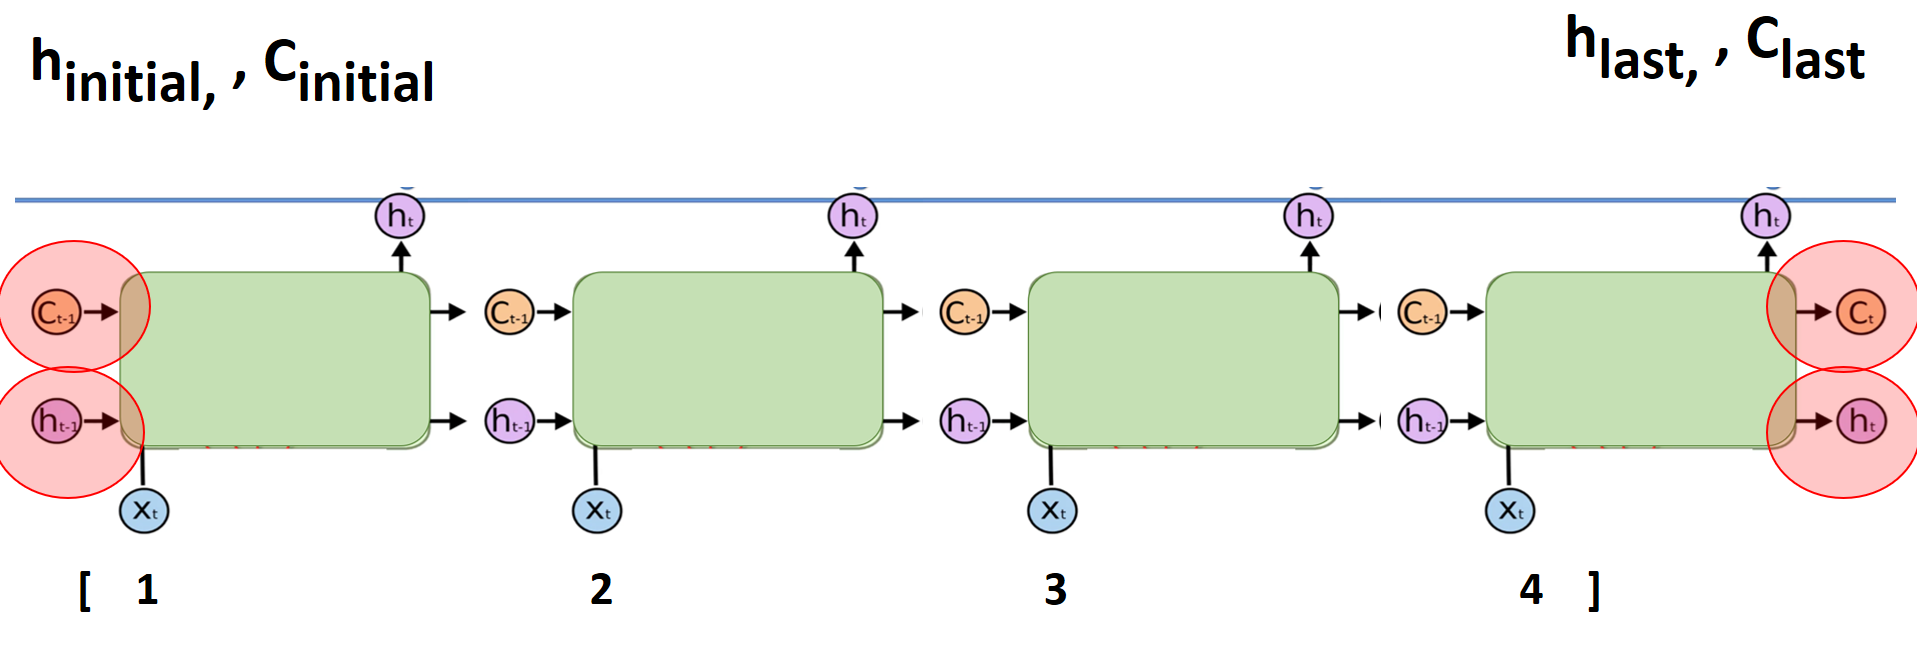

## Simple pseudocode representation of an LSTM cell and layer

    def LSTMcell(input)
    {
      ct = random()
      ht = f(input, ct)
      return ht, ct
    }

    def LSTMlayer(sequence)
    {
      ht, ct = random()
      for xt in sequence:
        ht, ct = LSTMcell(xt, ht, ct)
      return ht, ct
    }

**Note** thath in reality there is only one cell replicating itself

* **epochs** an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation

* **batch_size** a set of N samples. The samples in a batch are processed independently, in parallel. If training, a batch results in only one update to the model. A batch generally approximates the distribution of the input data better than a single input. The larger the batch, the better the approximation; however, it is also true that the batch will take longer to process and will still result in only one update. For inference (evaluate/predict), it is recommended to pick a batch size that is as large as you can afford without going out of memory (since larger batches will usually result in faster evaluation/prediction).

* **step**: $int\left(\frac{Total\,Samples}{batch\,size}\right)$

In [ ]:
epochs = 20 #@param {type:"integer"}
total_samples = X_train.shape[0]
batch_size = 32 #@param {type:"integer"}
steps_num = math.ceil(total_samples/batch_size)
print("Steps: ", steps_num)

Steps:  254


In [ ]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)



torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200, 1]) torch.Size([32, 24, 1])
torch.Size([32, 200,

In [ ]:
class Encoder(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    # Takes 1 time series value in this example, to hidden size
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(1, hidden_size, batch_first = True)

  def forward(self, encoder_inputs):
    # inputs: (batch size, input seq len, num enc features)
    batch_size = encoder_inputs.size(0)
    h0 = torch.zeros(1, batch_size, self.hidden_size).to(device) #(n_layers, batch_size, hidden_size)
    c0 = torch.zeros(1, batch_size, self.hidden_size).to(device) #(n_layers, batch_size, hidden_size)
    outputs, (h0,c0) = self.lstm(encoder_inputs, (h0,c0))
    # output: (batch size, input seq len, hidden size)
    # hidden: (num rnn layers, batch size, hidden size)
    return outputs, (h0,c0)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # Also takes 1 time series value
        self.lstm = nn.LSTMCell(1, hidden_size)
        # The output layer transforms the latent representation
        # back to a single prediction
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, initial_input, h, c, targets,
                teacher_force_probability):
        # NOTE:
        # initial_input is X_t
        # hidden is Z
        # targets looks like: [X_t+1, X_t+2, X_t+3, ...]
        # encoder_outputs are not used, but will be for attention later
        batch_size = initial_input.shape[0]
        decoder_sequence_length = targets.shape[1]

        # Store decoder outputs
        outputs = torch.zeros(batch_size, decoder_sequence_length, 1).to(device)
        input_at_t = initial_input

        # Here we have to roll out the decoder sequence ourselves because of
        # sometimes teacher forcing
        for t in range(decoder_sequence_length):
            h0, c0 = self.lstm(input_at_t, (h,c))
            output = self.out(h0)
            # Set-up input for next timestep
            outputs[:,t,:] = output
            teacher_force = random.random() < teacher_force_probability
            # The next timestep's input will either be this timestep's
            # target or output
            input_at_t = targets[:,t,:] if teacher_force else output
        return outputs

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, lr):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.optimizer = torch.optim.Adam(self.parameters(), lr)
        # The best loss function to use depends on the problem.
        # We will see a different loss function later for probabilistic
        # forecasting
        self.loss_function = nn.L1Loss()

    def forward(self, encoder_inputs, targets, teacher_force_probability):
        encoder_outputs, (h0,c0) = self.encoder(encoder_inputs)
        outputs = self.decoder(encoder_inputs[:,-1,:], h0[0], c0[0], targets, teacher_force_probability)
        return outputs

    def compute_loss(self, outputs, targets):
        loss = self.loss_function(outputs, targets)
        return loss

    def optimize(self, outputs, targets):
        self.optimizer.zero_grad()
        loss = self.compute_loss(outputs, targets)
        loss.backward()
        self.optimizer.step()

In [ ]:
learning_rate = 0.01
hidden_size = 200
model = Seq2Seq(Encoder(hidden_size), Decoder(hidden_size), learning_rate)
model.to(device)


print(model)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(1, 200, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTMCell(1, 200)
    (out): Linear(in_features=200, out_features=1, bias=True)
  )
  (loss_function): L1Loss()
)


In [ ]:
def train_one_epoch(model, train_loader, device):
  model.train(True)
  print(f'Epoch {epoch +1}')
  running_loss = 0.0

  for batch_indx, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    output = model(x_batch, y_batch, 0.75)
    loss = model.compute_loss(output, y_batch)
    model.optimize(output, y_batch)

    running_loss += loss.item()
    if batch_indx % 100 == 99:
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss {1:.3f}'.format(batch_indx+1, avg_loss_across_batches))
      running_loss = 0.0
  loss_values = running_loss / len(train_loader)
  print()
  return loss_values


In [ ]:
def train_one_epoch_tfprob(model, train_loader, device, teacher_force_probability):
  model.train(True)
  print(f'Epoch {epoch +1}')
  running_loss = 0.0

  for batch_indx, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    output = model(x_batch, y_batch, teacher_force_probability)
    loss = model.compute_loss(output, y_batch)
    model.optimize(output, y_batch)

    running_loss += loss.item()
    if batch_indx % 100 == 99:
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss {1:.3f}'.format(batch_indx+1, avg_loss_across_batches))
      running_loss = 0.0
  loss_values = running_loss / len(train_loader)
  print()
  return loss_values


In [ ]:
def validate_one_epoch(model, test_loader, device):
  model.train(False)
  running_loss = 0.0

  for batch_indx, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch, y_batch, 0.25)
      loss = model.compute_loss(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()
  return avg_loss_across_batches


In [ ]:
def validate_one_epoch_tfprob(model, test_loader, device, teacher_force_probability):
  model.train(False)
  running_loss = 0.0

  for batch_indx, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch, y_batch, teacher_force_probability)
      loss = model.compute_loss(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()
  return avg_loss_across_batches


In [ ]:
train_loss_values = []
validate_loss_values = []

for epoch in range(epochs):
  loss_values_epoch = train_one_epoch(model, train_loader, device)
  train_loss_values.append(loss_values_epoch)
  val_loss_values_epoch = validate_one_epoch(model, test_loader, device)
  validate_loss_values.append(val_loss_values_epoch)


Epoch 1
Batch 100, Loss 0.320
Batch 200, Loss 0.212


KeyboardInterrupt: 

In [ ]:
plt.plot(train_loss_values, label='Training Loss')
#plt.plot(validate_loss_values, label='Validation Loss')
plt.title("Input lenght - 200 (Seq2Seq)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('LoadSeq2Seq200.png')
plt.show()
#files.download("LoadSeq2Seq200.png")

In [ ]:
plt.plot(validate_loss_values, label='Validation Loss')
plt.title("Input lenght - 200 (Seq2Seq)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('LoadSeq2Seq200Val.png')
plt.show()
files.download("LoadSeq2Seq200Val.png")

In [ ]:

probs =[0,0.25,0.5,0.75,1]
plt.title("Input lenght - 60 (Seq2Seq)")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
for prob in probs:
  train_loss_values = []
  validate_loss_values = []
  for epoch in range(epochs):
    loss_values_epoch = train_one_epoch_tfprob(model, train_loader, device, prob)
    train_loss_values.append(loss_values_epoch)
    val_loss_values_epoch = validate_one_epoch_tfprob(model, test_loader, device, prob)
    validate_loss_values.append(val_loss_values_epoch)
  label = 'Training loss ' + str(prob)
  plt.plot(train_loss_values, label=label)
  plt.legend()

plt.show()

In [ ]:
with torch.no_grad():
  predicted = model(X_train.to(device), Y_train.to(device), 0.25).to('cpu').numpy().flatten()

train_data = Y_train.numpy().flatten()
print(predicted.shape)
plt.plot(train_data, ls='--', label='Actual Close')
plt.plot(predicted, ls='--', label='Predicted Close [Seq2Seq]')

plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
dummies = np.zeros((predicted.shape[0], 100+1))
dummies[:, 0] = predicted
dummies = scaler.inverse_transform(dummies)

predicted = dc(dummies[:, 0])
predicted

In [ ]:
dummies = np.zeros((predicted.shape[0], 100+1))
dummies[:, 0] = Y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

In [ ]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
  test_predictions = model(X_test.to(device), Y_test.to(device), 0.75).detach().cpu().numpy().flatten()


dummies = np.zeros((test_predictions.shape[0], 100+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, 0])


plt.plot(test_predictions, label='Predicted Close [LSTMCell]', color='orange')
plt.legend()
plt.show()

In [ ]:
dummies = np.zeros((test_predictions.shape[0], 100+1))
dummies[:, 0] = Y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])


In [ ]:

test_graph = plt.subplots(1,1, figsize=(10,10))[1]
test_graph.plot(test_predictions, label='Predicted Load [Seq2Seq]', color='orange', ls='-')
test_graph.plot(new_y_test, label='Actual Load', color='red', ls='dashdot')
test_graph.set_title('Test predictions vs. Actual values')
test_graph.set_xlabel('Hour')
test_graph.set_ylabel('Load')
plt.legend()
plt.savefig('StockLSTM.png')
plt.show()
#files.download("StockLSTM.png")

In [ ]:
MAE = []
MSE = []
RMSE = []
M = len(test_predictions)
for y1, y2 in zip(test_predictions, new_y_test):
  MAE.append(abs(y1-y2))
  MSE.append((y1-y2)**2)
  RMSE.append((y1-y2)**2)


plt.plot(MAE, label='MAE')
plt.plot(test_predictions, label='Predicted Load [Seq2Seq]', color='orange', ls='-')
plt.plot(new_y_test, label='Actual Load', color='red', ls='dashdot')
#plt.plot(MSE, label='MSE')
#plt.plot(RMSE, label='RMSE')
plt.legend()
plt.show()

MAE_T = sum(MAE)/M
MSE_T = sum(MSE)/M
RMSE_T = np.sqrt(sum(RMSE)/M)
print('MAE: ', MAE_T)
print('MSE: ', MSE_T)
print('RMSE: ', RMSE_T)